# **The Task No.1**

by Gulnara Siraeva, id 467474, J4232

In [ ]:
!pip install shap
!pip install lime
!pip install eli5


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
from prettytable import PrettyTable
import tqdm
import os

import shap as shap
import lime
import eli5

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error, classification_report
from sklearn.preprocessing import OrdinalEncoder
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from lime.lime_tabular import LimeTabularExplainer
from eli5.sklearn import PermutationImportance as EPerm
from IPython.display import HTML, display


# 1. Select the dataset and the ML problem (it is possible to select your old tasks from ML course or other ITMO courses implying ML/DL models).

## The Dataset about bank data: 
https://github.com/pycaret/pycaret/blob/master/datasets/bank.csv

### Description:
#### Customer data:
1 - age: age <br>
2 - job: type of job (administrator, worker, entrepreneur, maid, manager, pensioner, self-employed, service industry, student, technician, unemployed, unknown) <br>
3 - marital: marital status (divorced, married, not married, unknown; Note: "divorced" means divorced or widowed) <br>
4 - education: education (primary, secondary, higher and unknown) <br>
5 - default: has default credit? (no, yes, unknown.) <br>
6 - housing: is there a mortgage? (no, yes, unknown.) <br>
7 - loan: is there a personal loan? (no, yes, unknown.) <br>
8 - balance: balance.

#### Data on the last contact within the campaign:
9 - contact: type of contact ("cellular", "phone") <br>
10 - month: last contact month ('jan', 'feb', 'mar', ..., 'nov', 'dec') <br>
11 - day: last contact day of the week ('mon', 'tue', 'wed', 'thu', 'fri') <br>
12 - duration: duration of the last contact, in seconds <br>

#### Others:
13 - campaign: the number of contacts made during this campaign for this client (includes the last contact) <br>
14 - pdays: the number of days since the last contact with the customer from the previous campaign (999 means that the customer has not previously contacted) <br>
15 - previous: number of contacts made before this campaign for this client <br>
16 - poutcome: the result of a previous marketing campaign ("failure", "nonexistent", "success") <br>
17 - deposit: Has the client agreed to issue a term deposit? ("yes", "no")

# The goal is 
to predict whether the client will open deposit or not. So its binary classification problem with target variable of deposit column

In [3]:
# Lets upload the dataset
df = pd.read_csv(r'C:/Users/pasle/Downloads/bank.csv', sep = ',')
# drop all NAN values
df.dropna()
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
# Our target feature
df['deposit'].unique()

array(['no', 'yes'], dtype=object)

In [ ]:
# lets see the numerical features from the dataset
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [9]:
df.shape

(45211, 17)

In [5]:
# Here are all the columns in the dataset
columns_list = df.columns.tolist()
print(columns_list)

['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit']


In [11]:
# Lets check again for missing values
print(df.isnull().sum().sum())

0


In [6]:
# Lets transform the target variable from categorical into binary numerical values
df['deposit'] = (df['deposit'] == 'yes').astype(int)

In [7]:
# Lets check the unique values in target variable
df['deposit'].unique()

array([0, 1])

In [ ]:
# Lets transform the categorical features into numerical by OrdinalEncoding (not to multiply columns but use ordinal count whithin each column)
cat_columns = df.select_dtypes(include=['object']).columns.tolist()
encoder = OrdinalEncoder()
df[cat_columns] = encoder.fit_transform(df[cat_columns])


In [ ]:
# And all of our columns now presented as numerical feautures
df.describe()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,4.339762,1.167725,1.224813,0.018027,1362.272058,0.555838,0.160226,0.640242,15.806419,5.523014,258.163080,2.763841,40.197828,0.580323,2.559974,0.116985
std,10.618762,3.272657,0.608230,0.747997,0.133049,3044.765829,0.496878,0.366820,0.897951,8.322476,3.006911,257.527812,3.098021,100.128746,2.303441,0.989059,0.321406
min,18.000000,0.000000,0.000000,0.000000,0.000000,-8019.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,-1.000000,0.000000,0.000000,0.000000
25%,33.000000,1.000000,1.000000,1.000000,0.000000,72.000000,0.000000,0.000000,0.000000,8.000000,3.000000,103.000000,1.000000,-1.000000,0.000000,3.000000,0.000000
50%,39.000000,4.000000,1.000000,1.000000,0.000000,448.000000,1.000000,0.000000,0.000000,16.000000,6.000000,180.000000,2.000000,-1.000000,0.000000,3.000000,0.000000
75%,48.000000,7.000000,2.000000,2.000000,0.000000,1428.000000,1.000000,0.000000,2.000000,21.000000,8.000000,319.000000,3.000000,-1.000000,0.000000,3.000000,0.000000
max,95.000000,11.000000,2.000000,3.000000,1.000000,102127.000000,1.000000,1.000000,2.000000,31.000000,11.000000,4918.000000,63.000000,871.000000,275.000000,3.000000,1.000000


In [9]:
# Prepare the dataset for our task
y = df['deposit']
X = df.drop(['deposit'], axis=1)

In [ ]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)

# Reduce dataset size for memory management (I had the problem with the memory before so I have choden to reduce the size of dataset)
sample_size = 0.1
X_train, _, y_train, _ = train_test_split(X_train, y_train, train_size=sample_size, random_state=42, stratify=y_train)
X_test, _, y_test, _ = train_test_split(X_test, y_test, train_size=sample_size, random_state=42, stratify=y_test)

print(f"Reduced training set size: {X_train.shape[0]} samples")
print(f"Reduced testing set size: {X_test.shape[0]} samples")

Reduced training set size: 3616 samples
Reduced testing set size: 904 samples


#  2. Train the model and evaluate its accuracy.

In [11]:
# Apply the classification task
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [12]:
# Metrics for our model
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.91      0.96      0.94       795
           1       0.52      0.32      0.40       109

    accuracy                           0.88       904
   macro avg       0.72      0.64      0.67       904
weighted avg       0.86      0.88      0.87       904



The model performs well when predicting clients who will not open a deposit. It struggles to identify clients who will open a deposit (low recall and f1).

# Analyze the feature importance in the data for making predictions by your model using eli5/pdpbox/SHAP/LIME frameworks

## Calculate permutation importance, SHAP values, analyze predictions with LIME; plot 2D PDPs and other visualizations with SHAP framework of your choice.

PermutationExplainer explainer: 905it [03:38,  4.00it/s]                         



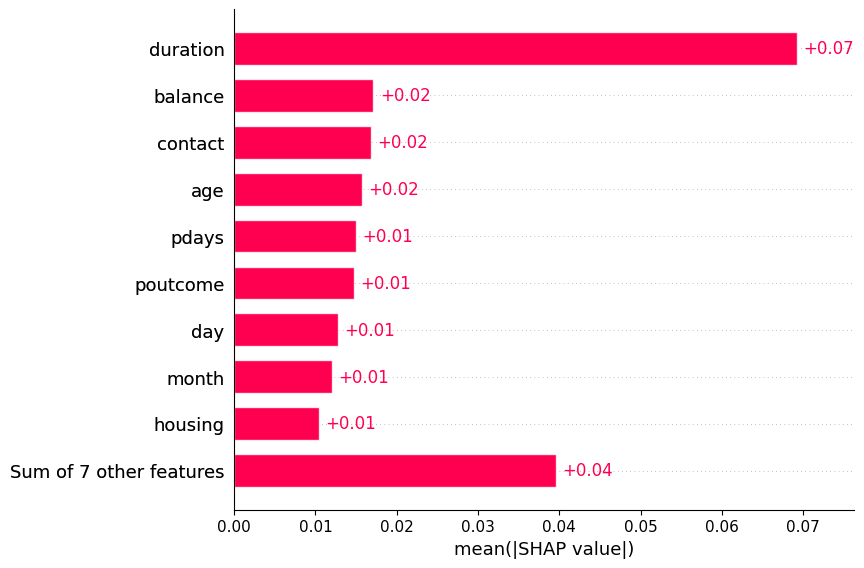

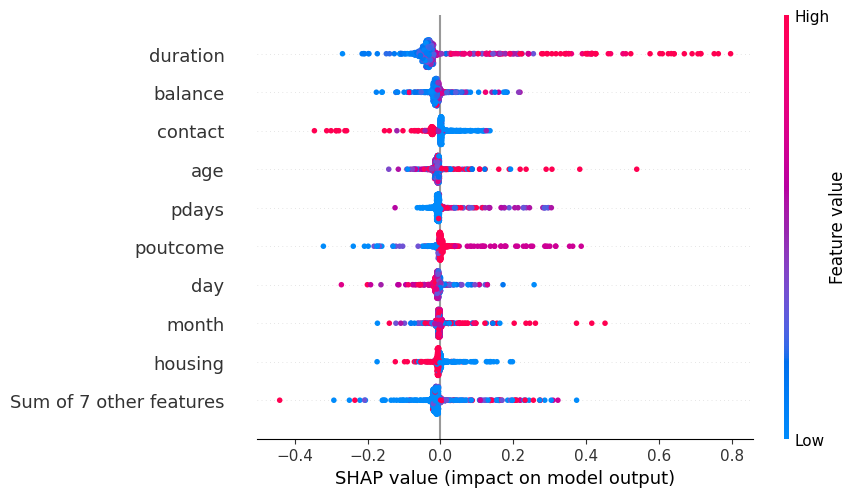

In [ ]:
# For shap
predict_fn = lambda x: model.predict(x).astype(float)
explainer = shap.Explainer(predict_fn, X_train, feature_names=X_train.columns)
shap_values = explainer(X_test)

# Plots
shap.plots.bar(shap_values)
shap.plots.beeswarm(shap_values)

Top features by permutation importance (mean):
duration     0.014602
poutcome     0.012537
pdays        0.005531
previous     0.004720
default      0.001069
month       -0.000442
loan        -0.001807
contact     -0.003540
marital     -0.004351
balance     -0.004535
housing     -0.005015
campaign    -0.005052
day         -0.005973
education   -0.006158
age         -0.007043
job         -0.008149
dtype: float64


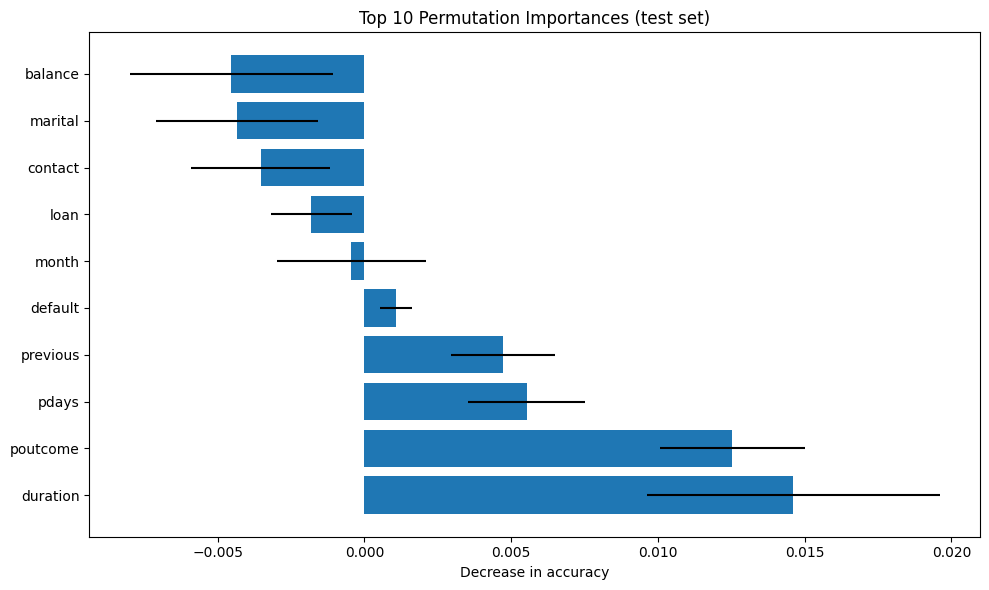

,mean_importance,std_importance
duration,0.014602,0.004991
poutcome,0.012537,0.002463
pdays,0.005531,0.001999
previous,0.004720,0.001759
default,0.001069,0.000533
month,-0.000442,0.002548
loan,-0.001807,0.001384
contact,-0.003540,0.002362
marital,-0.004351,0.002753
balance,-0.004535,0.003455


In [ ]:
# Permutation importance on the test set
result = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=42, n_jobs=-1, scoring='accuracy')

# mean importances
importances = pd.Series(result.importances_mean, index=X.columns)
importances_sorted = importances.sort_values(ascending=False)

print('Top features by permutation importance (mean):')
print(importances_sorted.head(20))

# top 10 features
top_n = 10
top_features = importances_sorted.index[:top_n]
means = importances_sorted.values[:top_n]
stds = pd.Series(result.importances_std, index=X.columns).loc[top_features].values
plt.figure(figsize=(10,6))
plt.barh(range(top_n)[::-1], means[::-1], xerr=stds[::-1], align='center')
plt.yticks(range(top_n)[::-1], top_features[::-1])
plt.xlabel('Decrease in accuracy')
plt.title(f'Top {top_n} permutation importances)')
plt.tight_layout()
plt.show()

# importance table
importance_df = pd.DataFrame({'mean_importance': result.importances_mean, 'std_importance': result.importances_std}, index=X.columns).sort_values('mean_importance', ascending=False)
importance_df.head(20)

c:\Users\pasle\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\inspection\_partial_dependence.py:717: FutureWarning: The column 0 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
c:\Users\pasle\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\inspection\_partial_dependence.py:717: FutureWarning: The column 5 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
c:\Users\pasle\AppData\Local\Pro

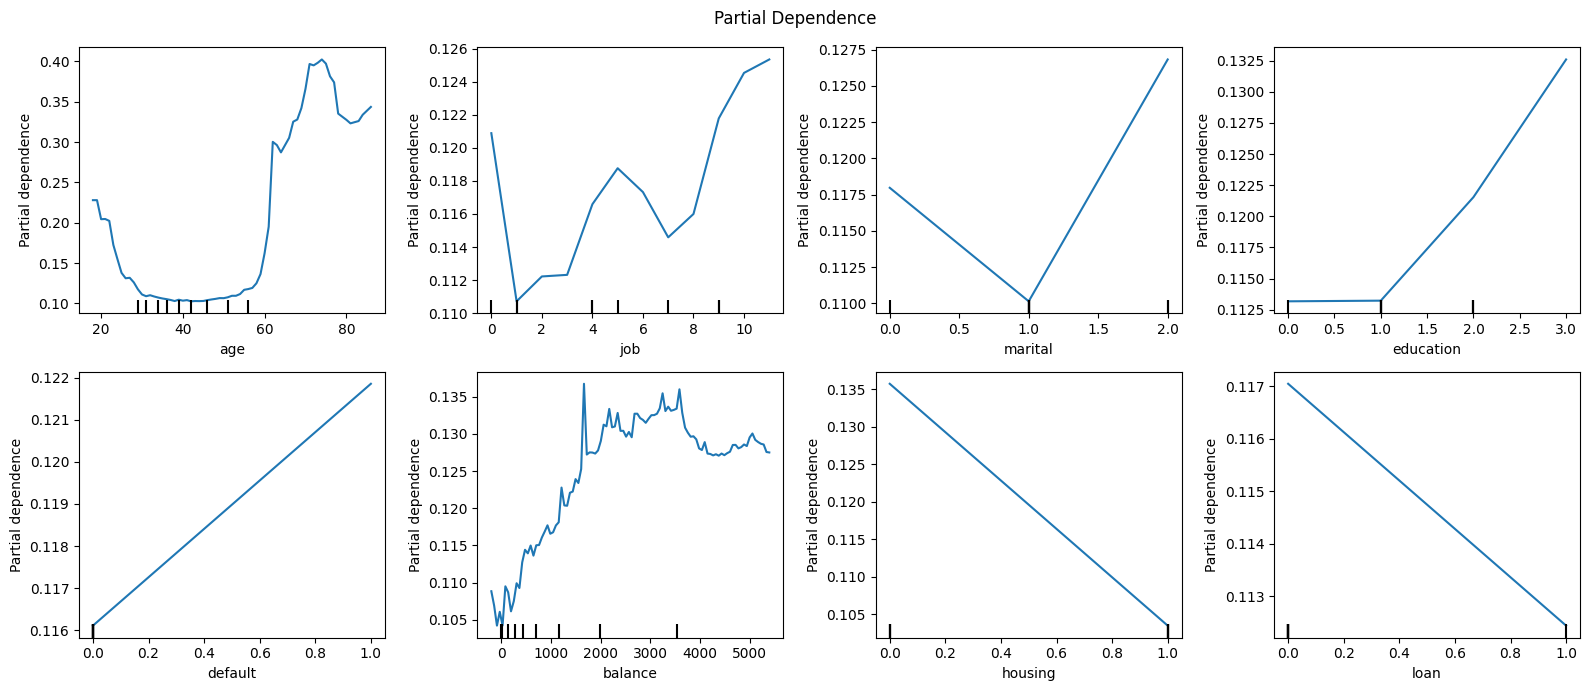

In [ ]:
# PartialDependenceDisplay (PDP) 
plt.figure(figsize=(16, 7))
# Limit to first 8 features to fit in a 2x4 grid
for i, feature_name in enumerate(X_test.columns[:8]):
    ax = plt.subplot(2, 4, i+1)
    PartialDependenceDisplay.from_estimator(model, X_train, [feature_name], ax=ax, kind='average')
plt.suptitle("Partial Dependence")
plt.tight_layout()
plt.show()

# Lime

In [ ]:
# LIME
X_train_np = X_train.values if hasattr(X_train, 'values') else np.asarray(X_train)
X_test_np = X_test.values if hasattr(X_test, 'values') else np.asarray(X_test)
feature_names = X_train.columns.tolist() if hasattr(X_train, 'columns') else [f'f{i}' for i in range(X_train_np.shape[1])]
class_names = ['no', 'yes']  

# LIME explainer for our classification task
explainer_lime = LimeTabularExplainer(X_train_np, feature_names=feature_names, class_names=class_names, mode='classification')

# index from X_test to explain
idx = min(5, len(X_test_np)-1)
sample = X_test_np[idx]

# predict_proba of LIME
try:
    exp = explainer_lime.explain_instance(sample, model.predict_proba, num_features=10)
    print('LIME explanation (as list):')
    print(exp.as_list())    
    display(HTML(exp.as_html()))
except Exception as e:
    print('LIME failed:', e)

c:\Users\pasle\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


LIME explanation (as list):
[('previous <= 0.00', -0.08233702405274654), ('pdays <= -1.00', -0.07737841537458082), ('contact <= 0.00', 0.04387068091991355), ('housing <= 0.00', 0.03928314240967231), ('balance <= 69.75', -0.02218186433090216), ('campaign > 3.00', -0.016321851606472034), ('175.00 < duration <= 316.00', -0.015848588914963022), ('default <= 0.00', -0.014640280439594264), ('month <= 3.00', -0.01043632183561942), ('age <= 33.00', -0.008465138829832929)]


Eli5

In [ ]:
# ELI5 Permutation importance
perm_eli5 = EPerm(estimator=model, scoring='accuracy', n_iter=30, random_state=42)
perm_eli5.fit(X_test, y_test)

# weights
try:
    # explain_weights 
    expl = eli5.explain_weights(perm_eli5, feature_names=X.columns.tolist())
    display(HTML(eli5.format_as_html(expl)))
except Exception as e:
    print('eli5 HTML display failed:', e)

# importances
try:
    weights_df = eli5.explain_weights_df(perm_eli5, feature_names=X.columns.tolist())
except Exception:
    try:
        fi = getattr(perm_eli5, 'feature_importances_', None)
        fi_std = getattr(perm_eli5, 'feature_importances_std_', None)
        weights_df = pd.DataFrame({'weight': fi, 'std': fi_std}, index=X.columns)
    except Exception as e:
        print('Failed to construct weights DataFrame:', e)
        weights_df = None


if weights_df is not None:    
    weight_col = [c for c in weights_df.columns if c not in ['feature', 'std', 'weight']][-1] if 'weight' not in weights_df.columns else 'weight'    
    weights_df_sorted = weights_df.sort_values(by=weight_col, ascending=False)
    print('Top features by ELI5 permutation importance:')
    display(weights_df_sorted.head(20))   


Weight,Feature
0.0134 ± 0.0117,duration
0.0125 ± 0.0067,poutcome
0.0068 ± 0.0050,pdays
0.0045 ± 0.0037,previous
0.0010 ± 0.0010,default
-0.0006 ± 0.0071,month
-0.0021 ± 0.0030,loan
-0.0027 ± 0.0053,contact
-0.0047 ± 0.0065,balance
-0.0047 ± 0.0036,housing


Top features by ELI5 permutation importance:


,feature,weight,std
0,duration,0.013422,0.005845
1,poutcome,0.012500,0.003333
2,pdays,0.006785,0.002486
3,previous,0.004462,0.001862
4,default,0.000996,0.000523
5,month,-0.000553,0.003553
6,loan,-0.002065,0.001477
7,contact,-0.002692,0.002644
8,balance,-0.004683,0.003227
9,housing,-0.004720,0.001782


# 4. Analyze all the graphs/tables and write conclusions about your model and feature importance (their global and local influence as well).

## 4.1 SHAP analysis 
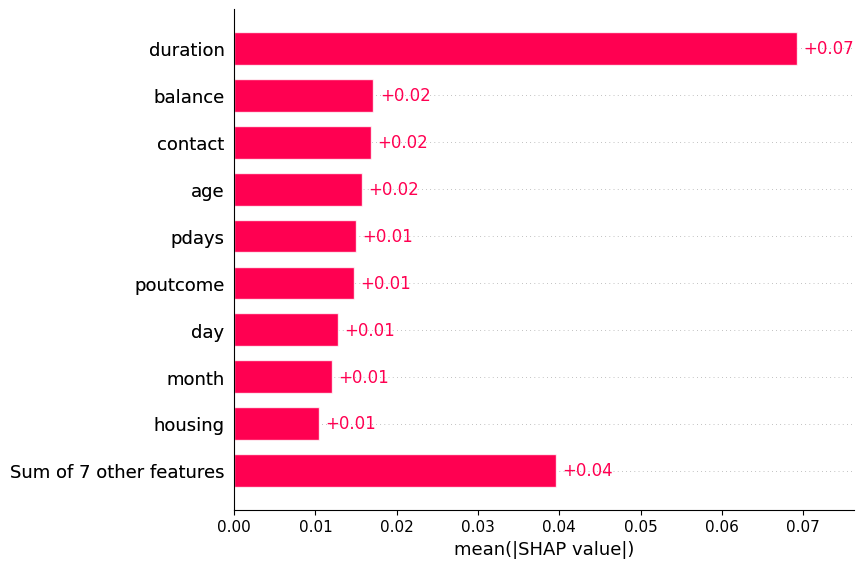
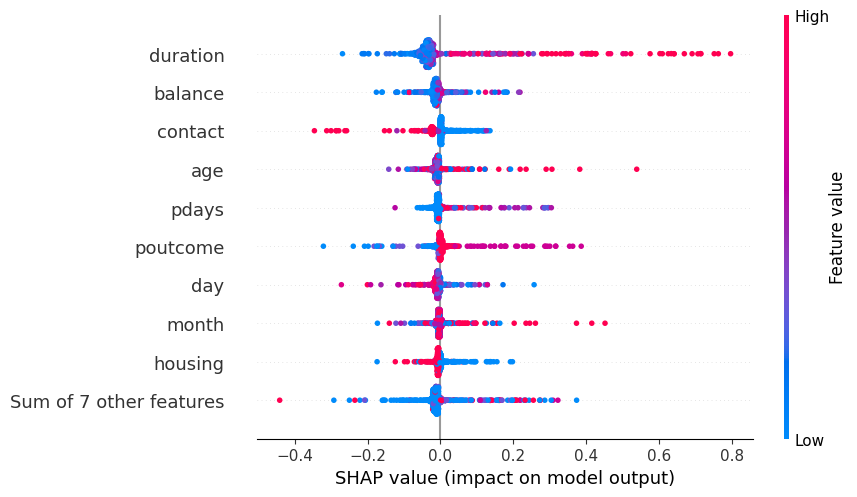


Shows that duration is the most influential feature for predicting deposit openings, much better than others such as balance, contact type, and demographic attributes. Longer contact duration and higher balance values both increase the chance of positive prediction. Non-linear relationships are observed, but  duration stands out as the main driver for the model’s decisions.

## 4.2 Permutation importance 
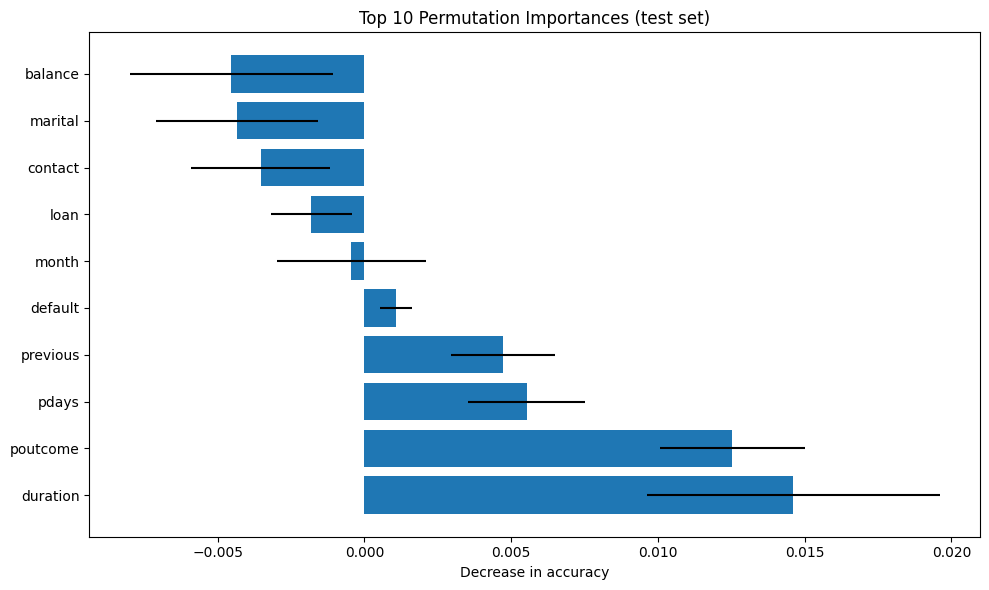


Permutation importance analysis demonstrates that the duration of the last contact is by far the most influential feature for predicting deposit openings, followed by previous marketing outcomes and the time since last contact. Most demographic and financial features, including balance and marital status, have minimal or negative impact on model accuracy. The model relies primarily on contact duration and recent campaign history, while other variables play only a minor role.

## 4.3 Partial dependence plots 
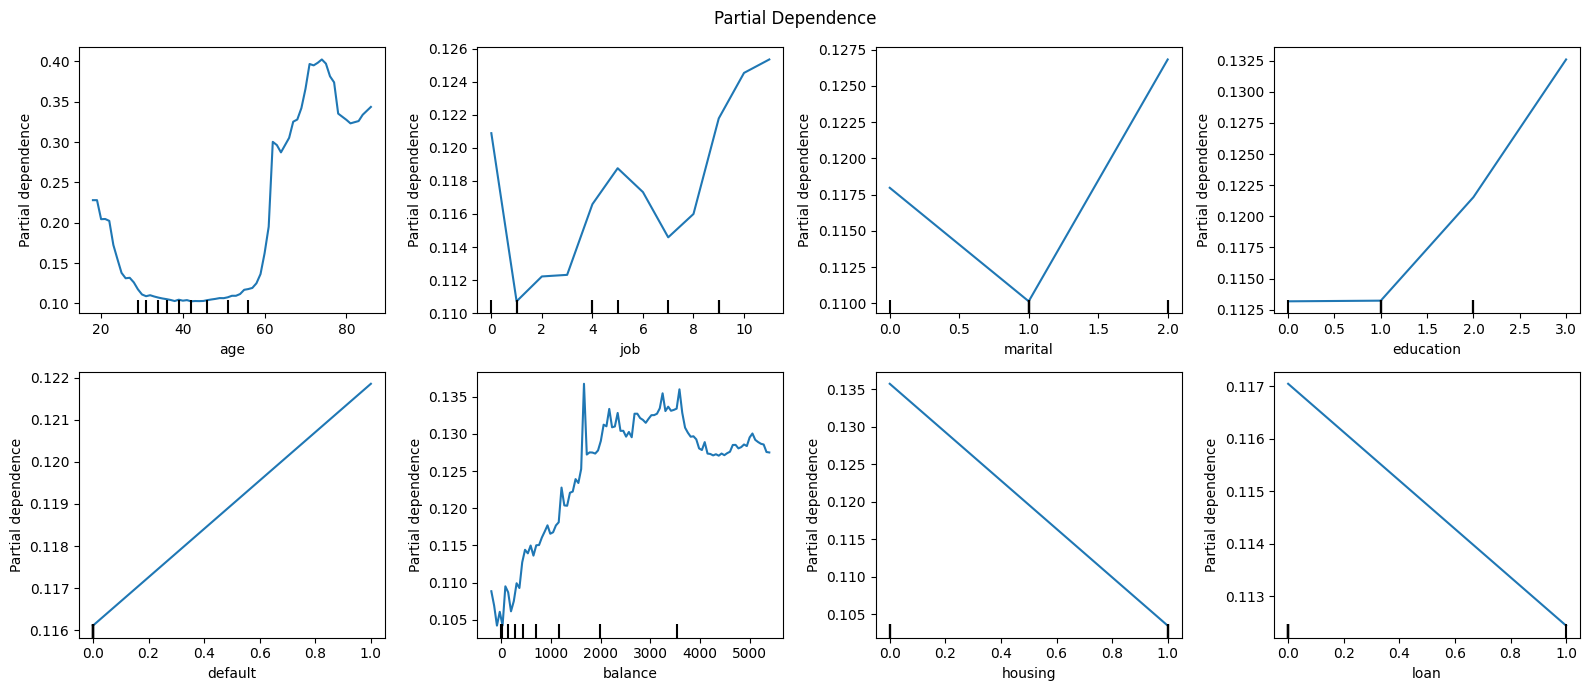

It shows how individual features impact the predicted probability of deposit opening. We can see that increasing age and balance generally lead to higher predicted probabilities, while features such as housing and loan have a negative linear effect on the model’s predictions. For categorical variables like job, marital, education, and default, the relationship is more complex, but the overall patterns suggest that specific categories and higher values in some features can significantly influence the outcome.

## 4.4 LIME
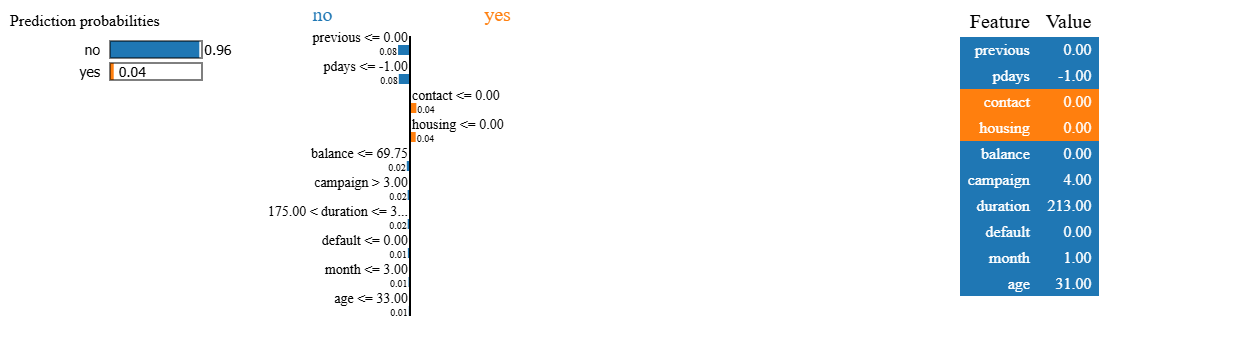

LIME explanation (as list):
[('previous <= 0.00', -0.08233702405274654), ('pdays <= -1.00', -0.07737841537458082), ('contact <= 0.00', 0.04387068091991355), ('housing <= 0.00', 0.03928314240967231), ('balance <= 69.75', -0.02218186433090216), ('campaign > 3.00', -0.016321851606472034), ('175.00 < duration <= 316.00', -0.015848588914963022), ('default <= 0.00', -0.014640280439594264), ('month <= 3.00', -0.01043632183561942), ('age <= 33.00', -0.008465138829832929)]


The model predicts a high probability for the "no deposit" outcome and a low probability for "yes." The main factors that decrease the likelihood of deposit opening are a low number of previous contacts, pdays, balance, and short campaign duration, along with younger age and absence of default. The presence of contact and housing features slightly increase the predicted probability of opening a deposit, but their influence is outweighed by the negative contributions of the other variables. Overall, the prediction is most strongly determined by recent campaign characteristics and client activity history.

## 4.5 ELI5
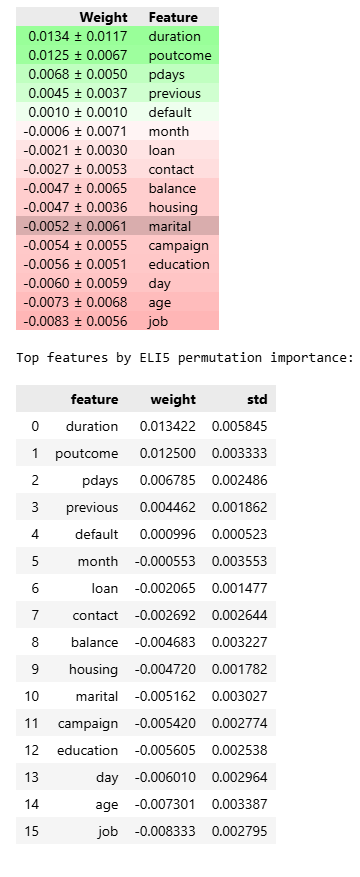

Duration and poutcome are the most influential features for the model, with pdays and previous contacts also making notable contributions to prediction accuracy. In contrast, demographic and product-related features such as job, age, day, education, campaign, and housing show negative or near-zero importance, indicating limited impact on the model's decision-making process. This means the model relies primarily on recent client interactions and marketing outcomes rather than static client attributes. Overall, the results suggest that information about customer engagement during the campaign is most critical for predicting deposit opening.

## 4.6 The comparision 
The comparision between evaluation models

In [19]:
# Create the comparison table
t = PrettyTable()
t.field_names = [
    "Model",
    "Top Positive Features",
    "Top Negative Features"
]

t.align["Model"] = "l"
t.align["Top Positive Features"] = "l"
t.align["Top Negative Features"] = "l"


t.add_row([
    "SHAP",
    "duration, balance, contact, age, pdays, poutcome, day, month, housing",
    "-"
])
t.add_row([
    "Permutation",
    "duration, poutcome, pdays, previous, default",
    "job, age, education, campaign, housing, balance, contact, marital, loan, month"
])
t.add_row([
    "ELI5",
    "duration, poutcome, pdays, previous, default",
    "job, age, education, campaign, housing, balance, contact, marital, loan, month"
])
t.add_row([
    "PartialDepends",
    "age, balance, education, default",
    "housing, loan"
])
t.add_row([
    "LIME",
    "contact, housing",
    "previous, pdays, balance, campaign, age, month, duration"
])

print(t)


+----------------+-----------------------------------------------------------------------+--------------------------------------------------------------------------------+
| Model          | Top Positive Features                                                 | Top Negative Features                                                          |
+----------------+-----------------------------------------------------------------------+--------------------------------------------------------------------------------+
| SHAP           | duration, balance, contact, age, pdays, poutcome, day, month, housing | -                                                                              |
| Permutation    | duration, poutcome, pdays, previous, default                          | job, age, education, campaign, housing, balance, contact, marital, loan, month |
| ELI5           | duration, poutcome, pdays, previous, default                          | job, age, education, campaign, housing, balance, 

Well, we can say that all models identify duration and recent campaign-related attributes, such as poutcome and pdays, as the most significant positive drivers for deposit opening. While SHAP, permutation importance, and ELI5 mostly agree on the top influential features, there are some differences in the ranking and in the identification of negatively contributing features, where demographic variables like job, age, and education appear most often. ELI5 and permutation model are atcually the same - just differs the goal of the model - one is more for vizualization (ELI5), but the results are the same as expected. 

Overall, all interpretability approaches highlight the dominant role of campaign engagement over static demographic data in predicting a client's decision.

# 5. Complete a task in a single Jupyter Notebook.

Done